# 一维 onsite Voltage 示例计算

[2020.12.21]

重复tkwant的示例： https://kwant-project.org/extensions/tkwant/tutorial/getting_started

**Notes:**

 - 使用简单边界条件。lead的长度足够长，在计算的时间区间内，边界反射回来的波就不会到达中心散射区，对计算结果不产生影响。
 
   本例中，快波（能量最大的波）可能已经被反射，到达中心散射区。但本例的目的是为了与tkwant的计算结果作对比，并不严格考察其物理意义。
   
   
 - 该系统不考虑电子相互作用，哈密顿量与电子波函数没有关系，所以得到一个单电子初态后，可以直接计算它的时间演化，不用同时计算整个多体态
 
 
 - Gauss-Kronrod 积分系数：
 
   https://people.sc.fsu.edu/~jburkardt/py_src/kronrod/kronrod.html
   
   https://people.sc.fsu.edu/~jburkardt/py_src/kronrod/kronrod.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.integrate import solve_ivp

##  一、对动量空间采样，用于积分

In [2]:
#[-1，1]区间内的kronrod method系数，结果是对称的
x = np.array([-0.99565716, -0.97390653, -0.93015749, -0.86506337, -0.78081773,
       -0.67940957, -0.56275713, -0.43339539, -0.29439286, -0.14887434,
        0.        ,  0.14887434,  0.29439286,  0.43339539,  0.56275713,
        0.67940957,  0.78081773,  0.86506337,  0.93015749,  0.97390653,
        0.99565716])
w = np.array([0.01169464, 0.03255816, 0.0547559 , 0.07503967, 0.09312545,
       0.10938716, 0.12349198, 0.13470922, 0.14277594, 0.1477391 ,
       0.14944555, 0.1477391 , 0.14277594, 0.13470922, 0.12349198,
       0.10938716, 0.09312545, 0.07503967, 0.0547559 , 0.03255816,
       0.01169464])

In [3]:
chemical_potential = 0
kmin = 0
kmax = np.arccos(1-(chemical_potential+1)/2)

In [4]:
# 将x映射到[0, kmax]
# 这里的posi表示k为正，即从左向右运动的粒子
momentum_posi_vec   = (x+1)/2*kmax
speed_posi_vec      = 2*np.sin(np.abs(momentum_posi_vec))
mathWeight_posi_vec = w    /2*kmax
physWeight_posi_vec = np.ones(w.size) /2/np.pi* speed_posi_vec
weight_posi_vec     = mathWeight_posi_vec * physWeight_posi_vec

In [5]:
#左行右行平面波简并
momentum_vec      = np.concatenate( (-momentum_posi_vec[::-1],momentum_posi_vec))
speed_vec         = np.concatenate( (speed_posi_vec[::-1], speed_posi_vec) )
weight_vec        = np.concatenate( (weight_posi_vec[::-1], weight_posi_vec) )

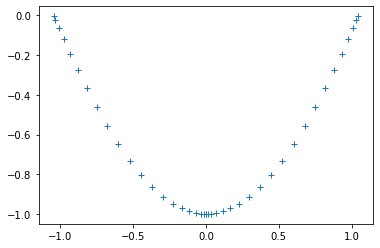

In [6]:
def dispersionRelation_func(momentum_vec):
    energy_vec = 2*(1 - np.cos(momentum_vec)) - 1
    return energy_vec

plt.plot(momentum_vec, dispersionRelation_func(momentum_vec), '+')

## 二、求解时域多体态

In [7]:
class onebody_wf:
    #simple boundery condition
    
    def __init__(self, momentum):
        self.momentum     = momentum
        self.energy       = 2*(1 - np.cos(momentum)) - 1
        self.speed        = 2*np.sin(abs(momentum))
        self.num_cell     = 100
        self.voltage_site = int(self.num_cell//2)      
        
    def hamitonian_timeDependent(self, time):
        def v_potential_func(time, tau=8):
            if time < tau:
                return time / tau
            return 1        
        #在hamitonian中加入电压的影响
        pos         = self.voltage_site
        diag_vec     = np.ones(self.num_cell, dtype=complex)
        diag_vec[pos]=diag_vec[pos] + v_potential_func(time)
        offdiag_vec  = - np.ones(self.num_cell - 1)        
        H            = scipy.sparse.diags([diag_vec, offdiag_vec, offdiag_vec], [0, 1, -1])

        return H

    def scatteringState(self):   
        #构建定态散射方程
        matrix_eq = self.hamitonian_timeDependent(0) - self.energy * sp.eye(self.num_cell)
        matrix_eq = sp.csr_matrix(matrix_eq)
        #边界条件
        #left
        matrix_eq[0,0]   = 1
        matrix_eq[0,1]   = -np.exp(-1j*abs(self.momentum))
        #right
        matrix_eq[-1,-1] = 1
        matrix_eq[-1,-2] = -np.exp(-1j*abs(self.momentum))
        #入射态
        right_vec        = np.zeros(self.num_cell, dtype=complex)
        if self.momentum>0:            
            right_vec[0] = 1/np.sqrt(self.speed)*(1-np.exp( 2j*self.momentum)) 
        else:
            right_vec[-1]= 1/np.sqrt(self.speed)*(1-np.exp(-2j*self.momentum)) 
        #求解线性方程组，得到散射初态
        self.psi_init     = spsolve(matrix_eq, right_vec)  
        
    def evolve(self, t_vec):  
        def dfdt_func(t, psi_bar_vec):
            H0 = self.hamitonian_timeDependent(0)
            H  = self.hamitonian_timeDependent(t)
            return  -1j*( ((H - self.energy * sp.eye(self.num_cell)) )@psi_bar_vec + (H - H0)@self.psi_init )
        
        # %% Solve differential equation
        #计算psi_bar
        sol = solve_ivp(dfdt_func, [t_vec[0], t_vec[-1]], np.zeros(self.num_cell,dtype=complex), t_eval=t_vec, rtol=1e-4,atol=1e-7) 
        #由psi_bar得到psi
        self.psi = np.zeros( (self.num_cell, t_vec.size), dtype=complex)
        for n_t in range(t_vec.size):
            time            = t_vec[n_t]
            self.psi[:,n_t] = (sol['y'][:,n_t] + self.psi_init) * np.exp(-1j*self.energy*(time-0))

In [8]:
t_vec           = np.linspace(0, 20)
manybody_wf_vec = []

for n_k in range(momentum_vec.size):
    #入射态的态指标
    k      = momentum_vec[n_k]
    #实例化
    wf_withMomentum = onebody_wf(k)
    #初态单体波函数
    wf_withMomentum.scatteringState()
    #时间演化
    wf_withMomentum.evolve(t_vec)
    #储存该态的演化数据
    manybody_wf_vec.append(wf_withMomentum)

## 计算density

In [9]:
density_vec = np.zeros( (5, t_vec.size) )
for n_t in range(t_vec.size):
    for n_k in range(momentum_vec.size):
        #提取波函数
        pos         = manybody_wf_vec[n_k].voltage_site
        psi_vec     = manybody_wf_vec[n_k].psi[:,n_t]
        
        #积分
        for n_site in range(5):
            density_vec[n_site, n_t] += (np.abs(psi_vec)**2)[pos+n_site]*weight_vec[n_k]

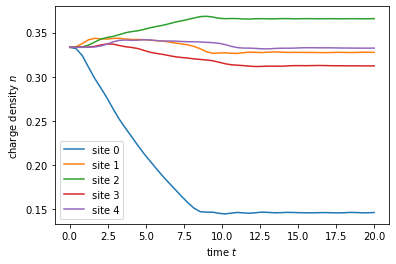

In [10]:
for n_site in range(5):
    plt.plot(t_vec, density_vec[n_site,:],label='site {}'.format(n_site))
    
plt.xlabel(r'time $t$')
plt.ylabel(r'charge density $n$')
plt.legend()
plt.show()